In [10]:
import pandas as pd
wada_dataset = 'data/raw/wada_filtered.csv'
wada_df = pd.read_csv(wada_dataset)
print(wada_df.head()) 
wada_df.shape

  DrugBank ID                       Name   Drug Groups  \
0     DB00014                  Goserelin      approved   
1     DB00035               Desmopressin      approved   
2     DB11323          Glycol salicylate      approved   
3     DB07447  5beta-dihydrotestosterone  experimental   
4     DB13758              Meclofenoxate  experimental   

                                              SMILES         Formula  Doping  
0  CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...    C59H84N18O14       1  
1  NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...  C46H64N14O12S2       1  
2                              OCCOC(=O)C1=CC=CC=C1O         C9H10O4       1  
3  [H][C@]1(O)CC[C@@]2([H])[C@]3([H])CC[C@]4([H])...        C19H30O2       1  
4                     CN(C)CCOC(=O)COC1=CC=C(Cl)C=C1     C12H16ClNO3       1  


(425, 6)

In [32]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
import numpy as np 
import os

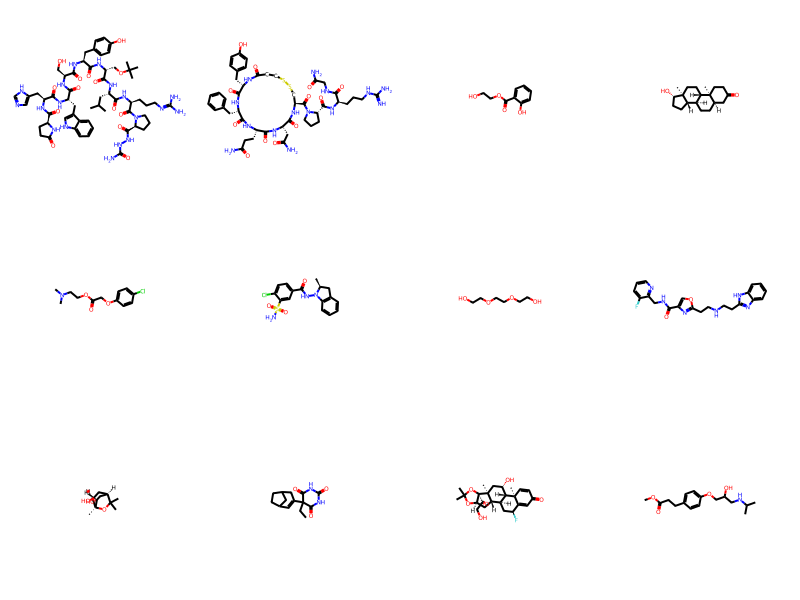

In [33]:
wada_df['SMILES'] = wada_df['SMILES'].astype(str).replace('nan', '')
sample_smiles = wada_df["SMILES"][0:12].values
sample_mols = [Chem.MolFromSmiles(smiles)for \
              smiles in sample_smiles]
grid = Draw.MolsToGridImage(sample_mols,
                           molsPerRow = 4,
                           subImgSize = (200,200))
grid

In [38]:
import os.path as osp

import torch
from torch_geometric.data import Dataset, Data, download_url

wada_df['SMILES'] = wada_df['SMILES'].astype(str).replace('nan', '')
class DopingDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None, pre_filter=None):
        self.test = test
        self.filename = filename
        super(DopingDataset, self).__init__(root, transform, pre_transform, pre_filter)
        


    @property
    def raw_file_names(self):
        return self.filename
        #return ['data/raw/wada_filtered.csv', 'some_file_2', ...]
    
    @property
    def processed_file_names(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        #return ['data_1.pt', 'data_2.pt', ...]

    def download(self):
        pass
        # Download to `self.raw_dir`.
        #path = download_url(url, self.raw_dir)
        

#     def process(self):
#         idx = 0
#         for raw_path in self.raw_paths:
#             # Read data from `raw_path`.
#             data = Data(...)

#             if self.pre_filter is not None and not self.pre_filter(data):
#                 continue

#             if self.pre_transform is not None:
#                 data = self.pre_transform(data)

#             torch.save(data, osp.join(self.processed_dir, f'data_{idx}.pt'))
#             idx += 1


    def process(self):
        self.data = pd.read_csv(self.raw_paths[0])
        #TQDM = how far our process is
        for index, mol in tqdm(wada_df.iterrows(), total=self.data.shape[0]):
            mol_obj = Chem.MolFromSmiles(mol["SMILES"])
            # Get node features
            node_feats = self._get_node_features(mol_obj)
            # Get edge features
            edge_feats = self._get_edge_features(mol_obj)
            # Get adjacency info
            edge_index = self._get_adjacency_info(mol_obj)
            # Get labels info
            label = self._get_labels(mol["Doping"])

            # Create data object
            data = Data(x=node_feats, 
                        edge_index=edge_index,
                        edge_attr=edge_feats,
                        y=label,
                        smiles=mol["SMILES"]
                        ) 
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{index}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{index}.pt'))

    def _get_node_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of Nodes, Node Feature size]
        """
        all_node_feats = []

        for atom in mol.GetAtoms():
            node_feats = []
            # Feature 1: Atomic number        
            node_feats.append(atom.GetAtomicNum())
            # Feature 2: Atom degree
            node_feats.append(atom.GetDegree())
            # Feature 3: Formal charge
            node_feats.append(atom.GetFormalCharge())
            # Feature 4: Hybridization
            node_feats.append(atom.GetHybridization())
            # Feature 5: Aromaticity
            node_feats.append(atom.GetIsAromatic())
            # Feature 6: Total Num Hs
            node_feats.append(atom.GetTotalNumHs())
            # Feature 7: Radical Electrons
            node_feats.append(atom.GetNumRadicalElectrons())
            # Feature 8: In Ring
            node_feats.append(atom.IsInRing())
            # Feature 9: Chirality
            node_feats.append(atom.GetChiralTag())

            # Append node features to matrix
            all_node_feats.append(node_feats)

        all_node_feats = np.asarray(all_node_feats)
        return torch.tensor(all_node_feats, dtype=torch.float)

    def _get_edge_features(self, mol):
        """ 
        This will return a matrix / 2d array of the shape
        [Number of edges, Edge Feature size]
        """
        all_edge_feats = []

        for bond in mol.GetBonds():
            edge_feats = []
            # Feature 1: Bond type (as double)
            edge_feats.append(bond.GetBondTypeAsDouble())
            # Feature 2: Rings
            edge_feats.append(bond.IsInRing())
            # Append node features to matrix (twice, per direction)
            all_edge_feats += [edge_feats, edge_feats]

        all_edge_feats = np.asarray(all_edge_feats)
        return torch.tensor(all_edge_feats, dtype=torch.float)

    def _get_adjacency_info(self, mol):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        edge_indices = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            edge_indices += [[i, j], [j, i]]

        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.t().to(torch.long).view(2, -1)
        return edge_indices

    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [39]:
dataset = DopingDataset(root = "data/", filename="wada_filtered.csv")

Processing...
100%|███████████████████████████████████████████████████████████████████████████████| 425/425 [00:01<00:00, 237.80it/s]
Done!


In [40]:
print(dataset[0].edge_index.t())
print(dataset[0].x)
print(dataset[0].edge_attr)
print(dataset[0].y)

tensor([[ 0,  1],
        [ 1,  0],
        [ 1,  2],
        [ 2,  1],
        [ 1,  3],
        [ 3,  1],
        [ 3,  4],
        [ 4,  3],
        [ 4,  5],
        [ 5,  4],
        [ 5,  6],
        [ 6,  5],
        [ 6,  7],
        [ 7,  6],
        [ 6,  8],
        [ 8,  6],
        [ 8,  9],
        [ 9,  8],
        [ 9, 10],
        [10,  9],
        [10, 11],
        [11, 10],
        [11, 12],
        [12, 11],
        [11, 13],
        [13, 11],
        [11, 14],
        [14, 11],
        [ 8, 15],
        [15,  8],
        [15, 16],
        [16, 15],
        [16, 17],
        [17, 16],
        [16, 18],
        [18, 16],
        [18, 19],
        [19, 18],
        [19, 20],
        [20, 19],
        [20, 21],
        [21, 20],
        [21, 22],
        [22, 21],
        [22, 23],
        [23, 22],
        [23, 24],
        [24, 23],
        [23, 25],
        [25, 23],
        [25, 26],
        [26, 25],
        [18, 27],
        [27, 18],
        [27, 28],
        [2